# dual_autodiff: Forward-Mode Automatic Differentiation

This notebook demonstrates the capabilities of the `dual_autodiff` package, focusing on forward-mode automatic differentiation. It provides a practical and theoretical foundation for working with dual numbers and their applications.

This notebook is useful for exploring how forward-mode automatic differentiation is applied in various domains, including optimization, machine learning, and computational mathematics. It also highlights the advantages of using `dual_autodiff`, such as improved speed and accuracy compared to traditional numerical differentiation techniques.

We will:
1. Perform basic arithmetic and compute derivatives using the `Dual` class.
2. Compare derivative calculations using:
    - Analytical methods.
    - Numerical methods (finite differences).
    - Dual numbers.
3. Analyze errors in numerical methods.
4. Compare the performance between Python and Cython implementations.

---

## Theory: Dual Numbers

Dual numbers are of the form:

$$
x = a + b\epsilon, \quad \text{where} \, \epsilon^2 = 0.
$$

Here, $ \epsilon $ is an infinitesimal unit satisfying $ \epsilon^2 = 0 $, which is a key property enabling automatic differentiation.

Using dual numbers, the derivative of a function can be computed as:

$$
f(a + b\epsilon) = f(a) + f'(a) b\epsilon,
$$

where:
- $ f(a) $: The value of the function at $ a $.
- $ f'(a) $: The derivative of the function at $ a $.

This approach eliminates the need for finite differences and avoids numerical instabilities, making it a robust alternative for derivative computations.

---

## Basic Arithmetic and Trigonometric Operations

Here, we demonstrate basic arithmetic (addition, subtraction, multiplication, division) and trigonometric/logarithmic operations using the `Dual` class.

### Arithmetic Operations
Dual numbers support standard arithmetic operations. For two dual numbers:

$$
x_1 = a_1 + b_1\epsilon \quad \text{and} \quad x_2 = a_2 + b_2\epsilon,
$$

the operations are defined as:
- Addition: $ x_1 + x_2 = (a_1 + a_2) + (b_1 + b_2)\epsilon $.
- Subtraction: $ x_1 - x_2 = (a_1 - a_2) + (b_1 - b_2)\epsilon $.
- Multiplication: $ x_1 \cdot x_2 = (a_1 a_2) + (a_1 b_2 + a_2 b_1)\epsilon $.
- Division: $ x_1 / x_2 = (a_1 / a_2) + ((b_1 a_2 - a_1 b_2) / a_2^2)\epsilon $.

### Trigonometric and Logarithmic Functions
Dual numbers also support common functions like:
- Trigonometric functions: $ \sin(x) $, $ \cos(x) $, $ \tan(x) $.
- Exponential and logarithmic functions: $ \exp(x) $, $ \log(x) $.
- Hyperbolic functions: $ \sinh(x) $, $ \cosh(x) $, $ \tanh(x) $.

Below are examples demonstrating these operations using the `Dual` class.


In [62]:
# Import necessary modules
from dual_autodiff.dual import Dual
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import timeit
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time


In [4]:
# Example 1: Basic arithmetic with dual numbers
x1 = Dual(2, 1)  # Dual number: 3 + ε
x2 = Dual(2, 2)  # Dual number: 2 + 2ε

# Addition
add_result = x1 + x2
print("Addition:", add_result)

# Subtraction
sub_result = x1 - x2
print("Subtraction:", sub_result)

# Multiplication
mul_result = x1 * x2
print("Multiplication:", mul_result)

# Division
div_result = x1 / x2
print("Division:", div_result)

# Example 2: Trigonometric functions

sin_result = x1.sin()
print("Sine of x1:", sin_result)

cos_result = x2.cos()
print("Cosine of x2:", cos_result)

tan_result = x1.tan()
print("Tangent of x1:", tan_result)

# Example 3: Logarithmic and exponential functions
log_result = x1.log()
print("Logarithm of x1:", log_result)

exp_result = x2.exp()
print("Exponential of x2:", exp_result)

# Example 4: Hyperbolic functions
sinh_result = x1.sinh()
print("Hyperbolic sine of x1:", sinh_result)

cosh_result = x2.cosh()
print("Hyperbolic cosine of x2:", cosh_result)

# Example 5: Handling Edge Cases
try:
    invalid_log = Dual(-1, 0).log()  # Logarithm of a negative number
except ValueError as e:
    print("Error:", e)


Addition: 4 + 3ε
Subtraction: 0 + -1ε
Multiplication: 4 + 6ε
Division: 1.0 + -0.5ε
Sine of x1: 0.9092974268256817 + -0.4161468365471424ε
Cosine of x2: -0.4161468365471424 + -1.8185948536513634ε
Tangent of x1: -2.185039863261519 + 5.774399204041917ε
Logarithm of x1: 0.6931471805599453 + 0.5ε
Exponential of x2: 7.38905609893065 + 14.7781121978613ε
Hyperbolic sine of x1: 3.6268604078470186 + 3.7621956910836314ε
Hyperbolic cosine of x2: 3.7621956910836314 + 7.253720815694037ε
Error: Logarithm undefined for non-positive real part.


---
# Derivatives

In this section, we aim to compute the derivative of the following function:

$$
f(x) = \ln(\sin(x)) + x^2 \cos(x)
$$

at $x = 1.5$, using three different methods:

1. **Analytical Derivative**: Derived explicitly using calculus.
2. **Numerical Derivative**: Estimated using finite differences.
3. **Dual Numbers**: Leveraging automatic differentiation with the `Dual` class and its differentiate function.


In [61]:
from dual_autodiff.dual import Dual, differentiate

# Define the function f(x)
def f(x):
    """
    Function definition: f(x) = log(sin(x)) + x^2 * cos(x)
    """
    return np.log(np.sin(x)) + (x**2) * np.cos(x)

# Analytical Derivatives
def analytical_derivative(x):
    """
    First derivative: f'(x) = cot(x) + 2x*cos(x) - x^2*sin(x)
    """
    return (np.cos(x) / np.sin(x)) + 2 * x * np.cos(x) - x**2 * np.sin(x)

def analytical_second_derivative(x):
    """
    Second derivative: f''(x) = -csc^2(x) + 2cos(x) - 4x*sin(x) - x^2*cos(x)
    """
    return (-1 / (np.sin(x)**2)) + 2 * np.cos(x) - 4 * x * np.sin(x) - x**2 * np.cos(x)

def analytical_third_derivative(x):
    """
    Third derivative: f'''(x) = 2csc^2(x)cot(x) - 6sin(x) - 6x*cos(x) + x^2*sin(x)
    """
    return (2 / np.sin(x)**2) * (np.cos(x) / np.sin(x)) - 6 * np.sin(x) - 6 * x * np.cos(x) + x**2 * np.sin(x)

def analytical_fifth_derivative(x):
    """
    Fifth derivative: Derived analytically and implemented here.
    """
    return (-8 / np.sin(x)**2) * (np.cos(x) / np.sin(x)) + 24 * (1 / np.sin(x)**4) * (np.cos(x) / np.sin(x)) \
           + 20 * np.sin(x) + 10 * x * np.cos(x) - x**2 * np.sin(x)

# Numerical Derivative using finite differences
def numerical_derivative(x, h=1e-8):
    """
    Numerical derivative using the central difference method.
    """
    return (f(x + h) - f(x - h)) / (2 * h)

# Evaluate derivatives at x = 1.5
x_value = 1.5

# Compute Analytical Derivatives
analytical_first_result = analytical_derivative(x_value)
analytical_second_result = analytical_second_derivative(x_value)
analytical_third_result = analytical_third_derivative(x_value)
analytical_fifth_result = analytical_fifth_derivative(x_value)

# Compute Numerical Derivative
numerical_result = numerical_derivative(x_value)

# Compute Dual Derivative Using the API
dual_first_result = differentiate(f, x_value)

# Print Results
print(f"Analytical First Derivative at x = {x_value}: {analytical_first_result:.12f}")
print(f"Analytical Second Derivative at x = {x_value}: {analytical_second_result:.12f}")
print(f"Analytical Third Derivative at x = {x_value}: {analytical_third_result:.12f}")
print(f"Analytical Fifth Derivative at x = {x_value}: {analytical_fifth_result:.12f}")
print(f"Numerical Derivative at x = {x_value}: {numerical_result:.12f}")
print(f"Dual Numbers First Derivative at x = {x_value}: {dual_first_result:.12f}")


Analytical First Derivative at x = 1.5: -1.961237270553
Analytical Second Derivative at x = 1.5: -7.007683135184
Analytical Third Derivative at x = 1.5: -4.234698076701
Analytical Fifth Derivative at x = 1.5: 19.915539577906
Numerical Derivative at x = 1.5: -1.961237261483
Dual Numbers First Derivative at x = 1.5: -1.961237270553


# Higher-Order Derivatives: Analysis and Visualization

This section visualizes the function $f(x) = \ln(\sin(x)) + x^2 \cos(x)$ and its higher-order derivatives. The purpose of this analysis is to examine the behavior of the derivatives and identify key points, such as zero crossings, which are significant for truncation error scaling in numerical differentiation.

The following aspects are analyzed:

1. **Absolute Value of the Third Derivative $|f'''(x)|$**:
   - Visualized to highlight regions where the truncation error dominates, as the error scales approximately as $\frac{h^2}{6} f'''(x)$.
   - Zero crossings of $f'''(x)$ are marked to identify points where truncation error dips.

2. **Absolute Value of the Fifth Derivative $|f^{(5)}(x)|$**:
   - Plotted to analyze its influence on higher-order error terms, which scale with $f^{(5)}(x)$.
   - Zero crossings of $f^{(5)}(x)$ are marked to investigate higher-order behavior.

The plots include zero crossings to better understand the relationships between higher-order derivatives and truncation errors in numerical differentiation.


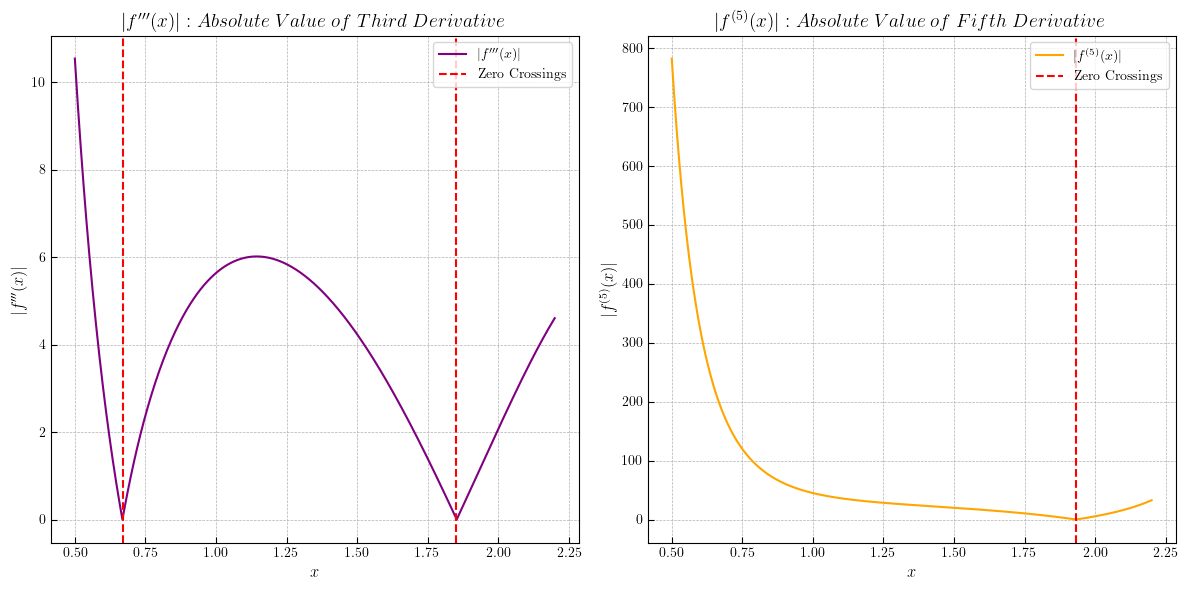

In [59]:
# Define the range of x values
x_values = np.linspace(0.5, 2.2, 1000)

# Compute function and derivatives
third_derivative_values = analytical_third_derivative(x_values)
fifth_derivative_values = analytical_fifth_derivative(x_values)
abs_third_derivative_values = np.abs(third_derivative_values)
abs_fifth_derivative_values = np.abs(fifth_derivative_values)

# Create the plot for third and fifth derivatives
plt.figure(figsize=(12, 6))

# Plot the absolute value of the third derivative with zero crossings
plt.subplot(1, 2, 1)
plt.plot(x_values, abs_third_derivative_values, label=r"$|f'''(x)|$", color="purple")

# Identify zero crossings of f'''(x)
third_sign_changes = np.where(np.diff(np.sign(third_derivative_values)))[0]
for idx in third_sign_changes:
    zero_x = (x_values[idx] + x_values[idx + 1]) / 2  # Approximate zero crossing
    plt.axvline(zero_x, color="red", linestyle="--")

plt.title(r"$|f'''(x)|: Absolute \; Value \; of \; Third \; Derivative$", fontsize=14)
plt.xlabel("$x$")
plt.ylabel(r"$|f'''(x)|$")
plt.legend(["$|f'''(x)|$", "Zero Crossings"], loc="upper right")
plt.grid(True)

# Plot the absolute value of the fifth derivative with zero crossings
plt.subplot(1, 2, 2)
plt.plot(x_values, abs_fifth_derivative_values, label=r"$|f^{(5)}(x)|$", color="orange")

# Identify zero crossings of f^(5)(x)
fifth_sign_changes = np.where(np.diff(np.sign(fifth_derivative_values)))[0]
for idx in fifth_sign_changes:
    zero_x = (x_values[idx] + x_values[idx + 1]) / 2  # Approximate zero crossing
    plt.axvline(zero_x, color="red", linestyle="--")

plt.title(r"$|f^{(5)}(x)|: Absolute \; Value \; of \; Fifth \; Derivative$", fontsize=14)
plt.xlabel("$x$")
plt.ylabel(r"$|f^{(5)}(x)|$")
plt.legend(["$|f^{(5)}(x)|$", "Zero Crossings"], loc="upper right")
plt.grid(True)

plt.tight_layout()

plt.savefig("third_and_fifth_derivatives.pdf", format="pdf", bbox_inches="tight")

plt.show()


---
# Derivative Errors: Numerical (Finite Difference and Floating-Point Regimes) vs Dual Numbers

This plot visualizes the absolute errors for numerical derivatives computed using finite differences across two distinct regimes: the **finite difference regime** and the **floating-point precision regime**. Additionally, the errors for the derivative calculated using dual numbers (via the `differentiate` function) are plotted for comparison.

#### Key Points:
1. **Finite Difference Regime**:
   - Corresponds to larger step sizes ($h$ values).
   - The error is dominated by **truncation error**, arising from the Taylor series approximation used in finite difference methods. For central difference methods, this truncation error scales as $\mathcal{O}(h^2)$.
   - Represented by blue solid lines for various $h$ values, this regime shows decreasing error as $h$ becomes smaller, up to a critical threshold.

2. **Floating-Point Precision Regime**:
   - Occurs when $h$ becomes very small.
   - The error begins to increase due to **floating-point rounding errors**, which dominate because of limited numerical precision when subtracting nearly equal numbers in $(f(x + h) - f(x - h)) / (2h)$.
   - Represented by red solid lines for various $h$ values, this regime demonstrates how excessively small step sizes degrade accuracy rather than improve it.

3. **Dual Numbers**:
   - Dual numbers leverage symbolic-like computation by embedding derivatives directly into the arithmetic through the dual part of a dual number, using the `differentiate` function. This eliminates the need for finite differencing or step size $h$.
   - Since dual numbers compute derivatives based on the chain rule and do not rely on approximations, their precision is effectively at the **machine epsilon level**—the smallest representable difference between floating-point numbers in the system.
   - Represented by a black line, the errors from dual numbers remain consistently low and independent of $h$ across the range of $x$ values.

#### Observations:
- **Finite Difference Regime**: Numerical errors decrease with smaller $h$ until truncation errors are outweighed by floating-point errors.
- **Floating-Point Precision Regime**: Numerical errors increase sharply as $h$ decreases further due to rounding errors, which are unavoidable in floating-point arithmetic.
- **Dual Numbers**: Their precision is inherently tied to the machine's numerical precision (not step sizes), making them free of truncation or step-size-related errors. This robustness highlights their superiority for applications requiring high precision, especially in scenarios where tuning $h$ for numerical derivatives is impractical.

This underscores the limitations of finite difference methods and the advantages of dual numbers (via the `differentiate` function), especially in scenarios requiring consistently high accuracy.


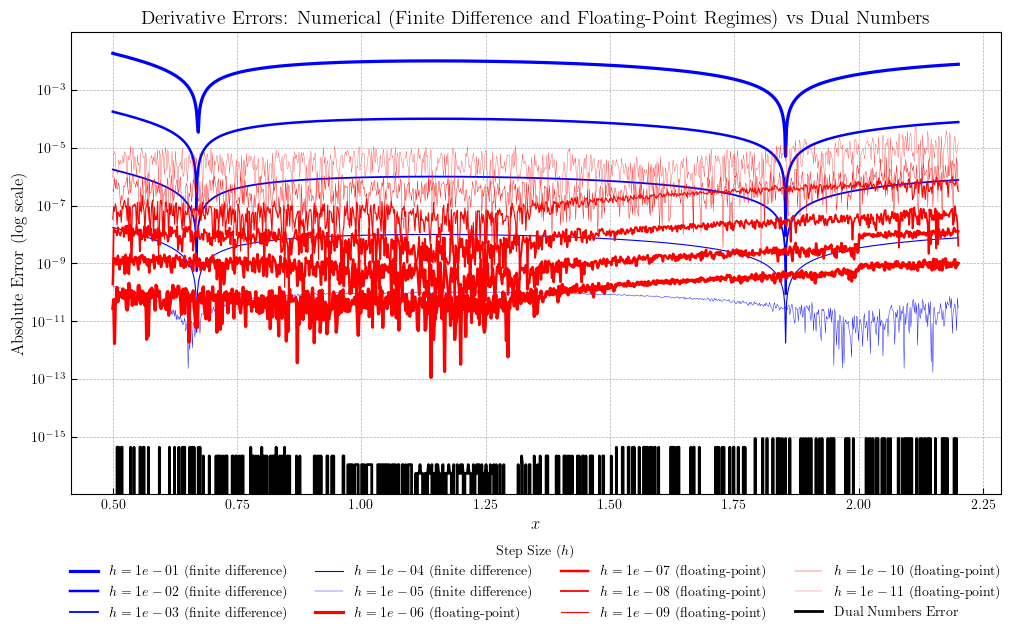

In [64]:
from dual_autodiff.dual import differentiate

# Define x-values and analytical derivative
x_values = np.linspace(0.5, 2.2, 1000)
analytical_values = np.array([analytical_derivative(x) for x in x_values])

# Define step sizes for finite difference and floating-point regimes
finite_difference_h_values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
floating_point_h_values = [1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11]

# Compute errors in the finite difference regime
numerical_errors_fd = {
    h: np.abs(np.array([numerical_derivative(x, h) for x in x_values]) - analytical_values)
    for h in finite_difference_h_values
}

# Compute errors in the floating-point precision regime
numerical_errors_fp = {
    h: np.abs(np.array([numerical_derivative(x, h) for x in x_values]) - analytical_values)
    for h in floating_point_h_values
}

# Compute error for dual number derivatives
dual_values = np.array([differentiate(f, x) for x in x_values])
dual_error = np.abs(dual_values - analytical_values)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot errors for the finite difference regime (blue solid lines)
base_linewidth_blue = 2.3
linewidth_decrement_blue = 0.5
for idx, (h, errors) in enumerate(numerical_errors_fd.items()):
    plt.plot(
        x_values,
        errors,
        label=f"$h={h:.0e}$ (finite difference)",
        linestyle="-",
        linewidth=base_linewidth_blue - idx * linewidth_decrement_blue,
        color="blue"
    )

# Plot errors for the floating-point precision regime (red solid lines)
base_linewidth_red = 2.3
linewidth_decrement_red = 0.5
for idx, (h, errors) in enumerate(numerical_errors_fp.items()):
    plt.plot(
        x_values,
        errors,
        label=f"$h={h:.0e}$ (floating-point)",
        linestyle="-",
        linewidth=base_linewidth_red - idx * linewidth_decrement_red,
        color="red"
    )

# Plot error for dual number derivatives
plt.plot(
    x_values,
    dual_error,
    label="Dual Numbers Error",
    linestyle="-",
    color="black",
    linewidth=2
)

# Customize the plot
plt.yscale("log")  # Use log scale for y-axis
plt.title("Derivative Errors: Numerical (Finite Difference and Floating-Point Regimes) vs Dual Numbers")
plt.xlabel("$x$")
plt.ylabel("Absolute Error (log scale)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Add legend below the plot
plt.legend(
    title="Step Size ($h$)",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=4,
    frameon=False
)

# Save the plot as PDF
plt.savefig("numerical_vs_dual_errors.pdf", format="pdf", bbox_inches="tight")
plt.show()


---
# Average Absolute Derivative Error vs Step Size ($h$) Averaged Across $x$

This plot explores the scaling behavior of derivative error as a function of the step size $h$, averaged across all $x$ values, with a log-log representation. 

#### Scaling of Errors
- **Truncation Error** typically scales as $\propto h^2$, while **Round-Off Error** scales as $\propto 1/h$.
- When plotted on a log-log scale, these scaling behaviors appear as two straight lines with slopes of approximately $+1$ (round-off error) and $-2$ (truncation error).

#### Mathematical Representation
The combined error behavior forms a piecewise linear function in the log-log domain, which we model as:

$$
\log(\mathrm{Error}) = 
\begin{cases} 
m_1 (\log h - \log h_{\text{optimal}}) + \log e_{\text{optimal}}, & \text{if } \log h \leq \log h_{\text{optimal}} \\
m_2 (\log h - \log h_{\text{optimal}}) + \log e_{\text{optimal}}, & \text{if } \log h > \log h_{\text{optimal}}
\end{cases}
$$



where:
- $h_{\text{optimal}}$ is the step size at which the total error is minimized.
- $e_{\text{optimal}}$ is the corresponding error at $h_{\text{optimal}}$.
- $m_1$ and $m_2$ are the slopes of the round-off error and truncation error regions, respectively.

#### Fitting the Model
To determine $h_{\text{optimal}}$, we fit this piecewise linear function to the observed error data in the log-log scale. The optimal $h$ is identified as the breakpoint where the derivative error is minimized.

#### Plot Highlights
- The **black markers** show the observed derivative error for varying step sizes.
- The **red dashed line** corresponds to the truncation error region (scaling as $h^2$).
- The **green dashed line** corresponds to the round-off error region (scaling as $1/h$).
- The **red dot** indicates the optimal step size $h_{\text{optimal}}$ and its corresponding error $e_{\text{optimal}}$.

This approach allows us to precisely identify $h_{\text{optimal}}$ and visually confirm that the derivative error behaves as expected in both scaling regimes.


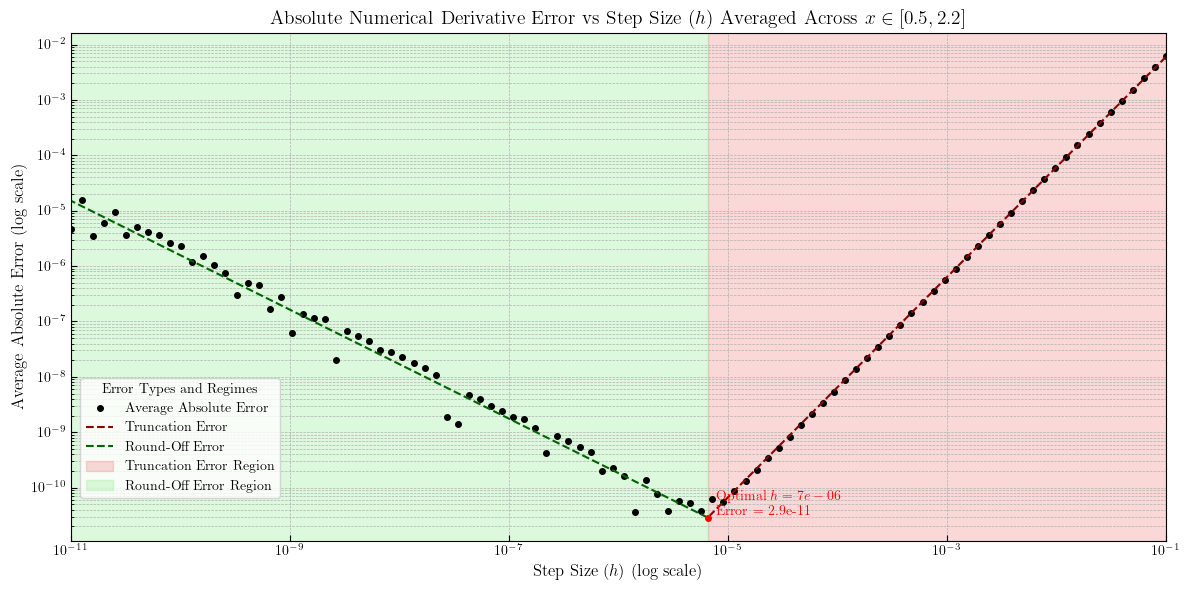

In [65]:
# Reload the style file
mpl.style.reload_library()
plt.style.use('latex_style.mplstyle')  # Use your updated style


x_values = np.linspace(0.5, 2.2, 1000)

# Define the range of step sizes (h)
h_values = np.logspace(-1, -11, 100)

# Compute the analytical derivative for all x-values
analytical_values = np.array([analytical_derivative(x) for x in x_values])

# Compute the numerical derivatives for each x-value and each h
numerical_errors = {}
for h in h_values:
    numerical_derivatives = np.array([numerical_derivative(x, h) for x in x_values])
    # Calculate the absolute error for each point in x and then average over all x-values
    numerical_errors[h] = np.mean(np.abs(numerical_derivatives - analytical_values))

# Convert numerical errors to arrays for easier handling
h_array = np.array(list(numerical_errors.keys()))
error_array = np.array(list(numerical_errors.values()))

# Take log-log of h and error
log_h = np.log10(h_array)
log_error = np.log10(error_array)

# Define the V-shaped piecewise linear function
def v_shape_model(x, x_break, m1, m2, e_opt):
    """
    Piecewise linear "V" model:
    - x_break: log(h) at the bottom of the V (optimal point)
    - m1: slope of the left line (truncation error region)
    - m2: slope of the right line (round-off error region)
    - e_opt: error at the bottom of the V
    """
    return np.piecewise(
        x,
        [x <= x_break, x > x_break],
        [
            lambda x: m1 * (x - x_break) + e_opt,
            lambda x: m2 * (x - x_break) + e_opt,
        ],
    )

# Initial guesses for parameters: x_break at the middle, m1 = -1, m2 = 2, e_opt = min(log_error)
initial_guess = [np.median(log_h), -1, 2, np.min(log_error)]

# Fit the V-shaped model to the log-log data
popt, _ = curve_fit(v_shape_model, log_h, log_error, p0=initial_guess)
x_break, m1, m2, e_opt = popt

# Convert the fitted x_break back to linear scale for plotting
optimal_h = 10**x_break  # Optimal h (bottom of the V)
optimal_error = 10**e_opt  # Error at the optimal h

# Plot the original error data
plt.figure(figsize=(12, 6))  

plt.plot(h_array, error_array, label="Average Absolute Error", color="black", marker="o", linestyle="None")

# Plot the truncation error (left side of the V)
smooth_log_h_left = np.linspace(log_h[0], x_break, 500)
fitted_error_left = 10**v_shape_model(smooth_log_h_left, *popt)
plt.plot(10**smooth_log_h_left, fitted_error_left, label="Truncation Error", color="darkred", linestyle="--")

# Plot the round-off error (right side of the V)
smooth_log_h_right = np.linspace(x_break, log_h[-1], 500)
fitted_error_right = 10**v_shape_model(smooth_log_h_right, *popt)
plt.plot(10**smooth_log_h_right, fitted_error_right, label="Round-Off Error", color="darkgreen", linestyle="--")

# Highlight the optimal h (bottom of the V) with a red dot and annotate it
plt.scatter(optimal_h, optimal_error, color="red", zorder=5)
plt.text(optimal_h * 1.2, optimal_error, 
         f"Optimal $h = {optimal_h:.0e}$\nError = {optimal_error:.1e}", 
          color="red", verticalalignment="bottom", horizontalalignment="left")

# Shade the area for truncation error (left of optimal h)
plt.axvspan(h_values[0], optimal_h, color='lightcoral', alpha=0.3, label="Truncation Error Region")

# Shade the area for round-off error (right of optimal h)
plt.axvspan(optimal_h, h_values[-1], color='lightgreen', alpha=0.3, label="Round-Off Error Region")
# Customize the plot
plt.xscale("log")
plt.yscale("log")
plt.xlim(h_values[-1], h_values[0])  # Reverse the limits to ensure increasing order

plt.title(
    r"Absolute Numerical Derivative Error vs Step Size ($h$) Averaged Across $x \in [0.5, 2.2]$",
    
    fontweight="bold",
)
plt.xlabel("Step Size ($h$) (log scale)")
plt.ylabel("Average Absolute Error (log scale)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Add a legend
plt.legend(
    title="Error Types and Regimes",
    loc="lower center",
    bbox_to_anchor=(0.1, 0.07),  # Position outside the plot
)
plt.tight_layout()
plt.savefig("Average_Absolute_Error.pdf", format="pdf", bbox_inches="tight")

plt.show()


---
# Execution Time Comparison for Derivative Methods

In this section, we evaluate the execution time of three different derivative computation methods—**analytical**, **numerical**, and **dual numbers**—over a large range of $x$ values:

1. **Analytical Derivative**: Directly computes the derivative using pre-derived mathematical expressions.
2. **Numerical Derivative**: Uses the central difference formula to approximate the derivative. The step size $h$ is varied logarithmically from $10^{-16}$ to $10^{-3}$.
3. **Dual Numbers**: Leverages automatic differentiation by representing $x$ as a dual number and evaluating the derivative from the dual component.

#### Observations
- **Numerical Derivative**: The execution time increases as $h$ decreases, as smaller step sizes require more precise arithmetic and introduce floating-point overheads.
- **Analytical Derivative**: This method is generally the fastest of the three because it relies on directly evaluating a pre-derived mathematical formula. There is no iterative computation or memory overhead, making it computationally efficient.
- **Dual Numbers**: This method is slower due to:
    - **Class Instantiation**: Each value is represented as a dual number, which requires creating an object with two components (real and dual).
    - **Overhead of Dual Arithmetic**: Operations like addition, multiplication, and trigonometric functions are overloaded to handle dual arithmetic, adding computational complexity.
    - **Memory Management**: Storing and accessing the dual components introduces additional memory and processing overhead compared to simple scalar operations.


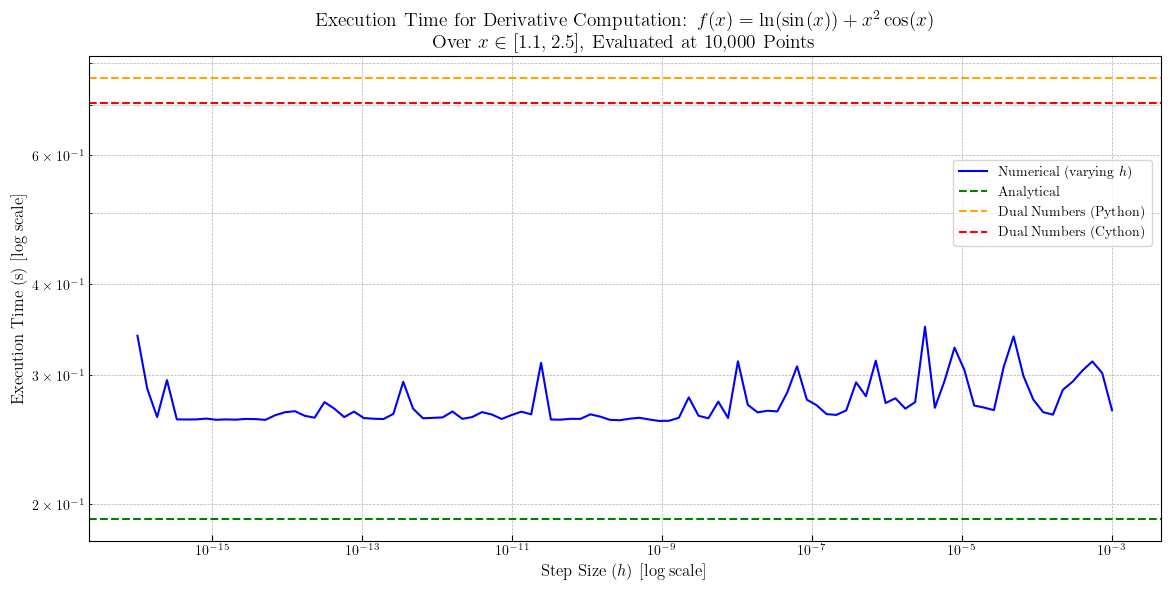

In [66]:
from dual_autodiff.dual import Dual as DualPython, differentiate as differentiate_python
from dual_autodiff_cython.dual import Dual as DualCython, differentiate as differentiate_cython

# Timing Functions for Range of x
def time_analytical_range():
    return [analytical_derivative(x) for x in x_values]

def time_numerical_range(h):
    return [numerical_derivative(x, h) for x in x_values]

def time_dual_range_python():
    return [differentiate_python(f, x) for x in x_values]

def time_dual_range_cython():
    return [differentiate_cython(f, x) for x in x_values]

# Set up x values
x_values = np.linspace(1.1, 2.5, 10000)  # Range of x values

# Step sizes for numerical method
numerical_h_values = np.logspace(-16, -3, 100)  # Range of h values for numerical derivatives

# Measure execution times
execution_times_range = {
    "analytical": timeit.timeit("time_analytical_range()", globals=globals(), number=10),
    "numerical": [
        timeit.timeit(
            stmt="time_numerical_range(h)",
            globals=globals(),
            number=10,
            setup=f"h={h}"
        )
        for h in numerical_h_values
    ],
    "dual_python": timeit.timeit("time_dual_range_python()", globals=globals(), number=10),
    "dual_cython": timeit.timeit("time_dual_range_cython()", globals=globals(), number=10),
}

# Plot the execution times
plt.figure(figsize=(12, 6))

# Plot numerical execution times for varying h
plt.plot(
    numerical_h_values,
    execution_times_range["numerical"],
    label="Numerical (varying $h$)",
    color="blue"
)

# Plot execution times for analytical, Python dual, and Cython dual methods
plt.axhline(
    execution_times_range["analytical"],
    color="green",
    linestyle="--",
    label="Analytical"
)
plt.axhline(
    execution_times_range["dual_python"],
    color="orange",
    linestyle="--",
    label="Dual Numbers (Python)"
)
plt.axhline(
    execution_times_range["dual_cython"],
    color="red",
    linestyle="--",
    label="Dual Numbers (Cython)"
)

# Log-log scale and labels
plt.xscale("log")
plt.yscale("log")
plt.title(
    "Execution Time for Derivative Computation: $f(x) = \ln(\sin(x)) + x^2\cos(x)$\n"
    "Over $x \in [1.1, 2.5]$, Evaluated at 10,000 Points",
    fontweight='bold'
)
plt.xlabel("Step Size ($h$) [log scale]")
plt.ylabel("Execution Time (s) [log scale]")

# Manually set the legend position
plt.legend(loc="upper left", bbox_to_anchor=(0.8, 0.8), fontsize=10)  

# loc specifies which corner of the legend box should align with bbox_to_anchor
# bbox_to_anchor=(1.05, 1) places the legend slightly to the right of the plot

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig("Execution_times_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()


# Performance Comparison: Python vs Cython Implementations

This section presents a detailed comparison of the **percentage speedup** achieved by the **Cythonized implementation** over the **pure Python implementation** for various operations involving dual numbers. The benchmarks cover three major categories:

### 1. Arithmetic, Logarithmic, and Exponential Functions
These operations, including $x + y$, $x - y$, $x \times y$, $x / y$, $\exp(x)$, and $\log(x)$, form the foundation of numerical computations. Benchmarking these functions provides a baseline to evaluate the computational overhead of each implementation.

- **Key Insights**:
  - Cython consistently outperforms Python by optimizing fundamental numerical operations.
  - Speedups in this category highlight reduced overhead from Python’s dynamic type handling.

### 2. Trigonometric and Hyperbolic Functions
This category evaluates elementary trigonometric functions ($\sin(x)$, $\cos(x)$, $\tan(x)$) and hyperbolic functions ($\sinh(x)$, $\cosh(x)$, $\tanh(x)$), along with their inverses ($\sinh^{-1}(x)$, $\cosh^{-1}(x)$, $\tanh^{-1}(x)$).

- **Key Insights**:
  - These functions are computationally intensive due to transcendental evaluations.
  - Cython achieves significant speedups by leveraging compiled arithmetic and optimized transcendental function calls.

### 3. Differentiation of Functions
This category benchmarks derivatives of various machine learning-relevant functions, such as:
- $f(x) = \frac{1}{1 + e^{-x}}$: Sigmoid activation function used in classification.
- $f(x) = \tanh(x)$: Activation function for recurrent neural networks.
- $f(x) = \max(0, x)$: ReLU, a widely used deep learning activation function.
- $f(x) = \log(1 + e^x)$: SoftPlus, a smooth variant of ReLU.
- $f(x) = (x - 1)^2$: Mean Squared Error (MSE), a common loss function.
- $f(x) = -[y \log(x) + (1-y) \log(1-x)]$: Binary Cross-Entropy (BCE), used in binary classification tasks.

- **Key Insights**:
  - Differentiation benchmarks highlight Cython’s capability to accelerate composite function evaluation and derivative propagation.
  - The performance improvement is particularly notable for complex, non-linear functions.

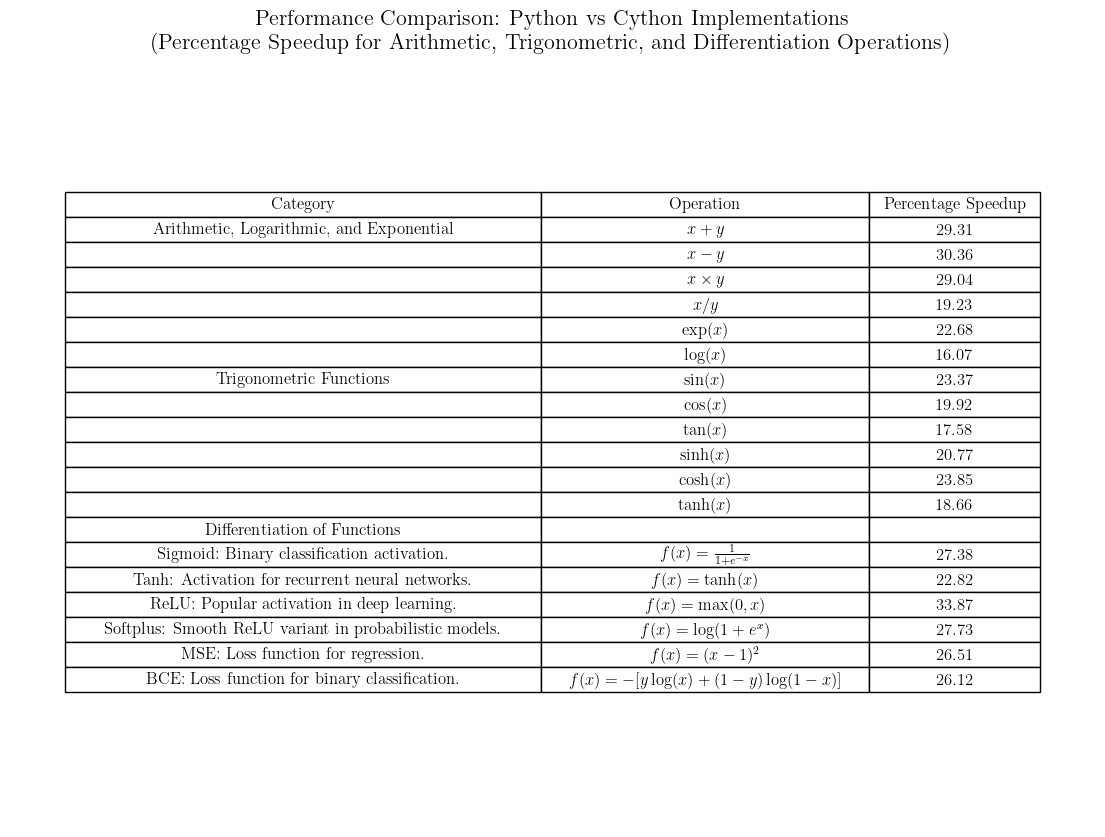

In [57]:
from dual_autodiff.dual import Dual as DualPython, differentiate as differentiate_python
from dual_autodiff_cython.dual import Dual as DualCython, differentiate as differentiate_cython

# Benchmark Function for Operations (Median)
def benchmark_operations_median(DualClass, iterations=100000, repetitions=5):
    """
    Benchmark basic arithmetic, trigonometric, and logarithmic operations using median timing.
    """
    results = {}
    x_general = DualClass(0.5, 1.0)  # General case
    x_acosh = DualClass(2.0, 1.0)    # For `acosh`

    operations = [
        ('addition', lambda: x_general + x_general),
        ('subtraction', lambda: x_general - x_general),
        ('multiplication', lambda: x_general * x_general),
        ('division', lambda: x_general / x_general),
        ('exp', lambda: x_general.exp()),
        ('log', lambda: x_general.log()),
        ('sin', lambda: x_general.sin()),
        ('cos', lambda: x_general.cos()),
        ('tan', lambda: x_general.tan()),
        ('sinh', lambda: x_general.sinh()),
        ('cosh', lambda: x_general.cosh()),
        ('tanh', lambda: x_general.tanh()),
        ('asinh', lambda: x_general.asinh()),
        ('acosh', lambda: x_acosh.acosh()),
        ('atanh', lambda: x_general.atanh())
    ]

    for op, operation in operations:
        timings = []
        for _ in range(repetitions):  # Repeat multiple times
            start_time = time.time()
            for _ in range(iterations):
                operation()
            timings.append(time.time() - start_time)
        results[op] = np.median(timings)  # Store median timing

    return results

# Benchmark Function for Differentiation (Median)
def benchmark_differentiation_median(DualClass, differentiate_func, iterations=10000, repetitions=5):
    """
    Benchmark differentiation of machine learning-relevant functions using median timing.
    """
    results = {}
    valid_input = 0.5  # Example valid input to avoid issues with log or power

    functions = {
        'f(x) = sigmoid(x)': lambda x: 1 / (1 + (-x).exp()),  # Sigmoid
        'f(x) = tanh(x)': lambda x: x.tanh(),                # Tanh
        'f(x) = relu(x)': lambda x: x * (x > 0),             # ReLU
        'f(x) = softplus(x)': lambda x: (1 + x.exp()).log(), # SoftPlus
        'f(x) = MSE(x, y=1)': lambda x: (x - 1)**2,          # Mean Squared Error
        'f(x) = BCE(x, y=1)': lambda x: -(
            1 * x.log() + (1 - 1) * (1 - x).log()
        )  # Binary Cross-Entropy
    }

    for name, func in functions.items():
        timings = []
        for _ in range(repetitions):  # Repeat multiple times
            start_time = time.time()
            for _ in range(iterations):
                differentiate_func(func, valid_input)  # Use adjusted input
            timings.append(time.time() - start_time)
        results[name] = np.median(timings)  # Store median timing

    return results


def prepare_table_data(speedup, derivative_speedup):
    """
    Organize data into a structured format for easy visualization,
    ensuring only one label per category section.
    """
    data = []

    # Arithmetic, Logarithmic, and Exponential
    data.append(["Arithmetic, Logarithmic, and Exponential", "$x + y$", f"{speedup['addition']:.2f}"])
    for op, math_expr in [
        ("subtraction", "$x - y$"),
        ("multiplication", "$x \\times y$"),
        ("division", "$x / y$"),
        ("exp", "$\\exp(x)$"),
        ("log", "$\\log(x)$"),
    ]:
        data.append(["", math_expr, f"{speedup[op]:.2f}"])  # Empty category for subsequent rows

    # Trigonometric Functions
    data.append(["Trigonometric Functions", "$\\sin(x)$", f"{speedup['sin']:.2f}"])
    for op, math_expr in [
        ("cos", "$\\cos(x)$"),
        ("tan", "$\\tan(x)$"),
        ("sinh", "$\\sinh(x)$"),
        ("cosh", "$\\cosh(x)$"),
        ("tanh", "$\\tanh(x)$"),
    ]:
        data.append(["", math_expr, f"{speedup[op]:.2f}"])  # Empty category for subsequent rows

    # Differentiation of Functions
    data.append(["Differentiation of Functions", "", ""])
    for op, math_expr, desc in [
        ("f(x) = sigmoid(x)", "$f(x) = \\frac{1}{1 + e^{-x}}$", "Sigmoid: Binary classification activation."),
        ("f(x) = tanh(x)", "$f(x) = \\tanh(x)$", "Tanh: Activation for recurrent neural networks."),
        ("f(x) = relu(x)", "$f(x) = \\max(0, x)$", "ReLU: Popular activation in deep learning."),
        ("f(x) = softplus(x)", "$f(x) = \\log(1 + e^x)$", "Softplus: Smooth ReLU variant in probabilistic models."),
        ("f(x) = MSE(x, y=1)", "$f(x) = (x - 1)^2$", "MSE: Loss function for regression."),
        ("f(x) = BCE(x, y=1)", "$f(x) = -[y \\log(x) + (1-y) \\log(1-x)]$", "BCE: Loss function for binary classification."),
    ]:
        data.append([desc, math_expr, f"{derivative_speedup[op]:.2f}"])  # Differentiation rows remain descriptive

    return pd.DataFrame(data, columns=["Category", "Operation", "Percentage Speedup"])


# Define the number of iterations for benchmarking
iterations_operations = 500000  # Number of iterations for basic operations
iterations_differentiation = 500000  # Number of iterations for differentiation

# Run Benchmarks with Median Timing
results_python = benchmark_operations_median(DualPython, iterations_operations, repetitions=5)
results_cython = benchmark_operations_median(DualCython, iterations_operations, repetitions=5)

derivative_python = benchmark_differentiation_median(DualPython, differentiate_python, iterations_differentiation, repetitions=5)
derivative_cython = benchmark_differentiation_median(DualCython, differentiate_cython, iterations_differentiation, repetitions=5)

# Calculate Percentage Speedup (Using Median)
speedup = {
    key: ((results_python[key] - results_cython[key]) / results_python[key]) * 100
    for key in results_python.keys()
}

derivative_speedup = {
    key: ((derivative_python[key] - derivative_cython[key]) / derivative_python[key]) * 100
    for key in derivative_python.keys()
}

# Generate the Table Data
table_data = prepare_table_data(speedup, derivative_speedup)

# Plot the Structured Table
fig, ax = plt.subplots(figsize=(14, 10))  # Adjust size for better fit
ax.axis('tight')
ax.axis('off')

# Create the Table
table = ax.table(
    cellText=table_data.values,
    colLabels=table_data.columns,
    loc='center',
    cellLoc='center',
)

# Style the Table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(table_data.columns))))
table.scale(1, 1.5)

# Remove gray shading for section headers
for row in range(len(table_data)):
    if table_data.iloc[row, 0] != "":
        for col in range(len(table_data.columns)):
            table[(row + 1, col)].set_facecolor("white")  # Set background to white

plt.title(
    "Performance Comparison: Python vs Cython Implementations\n"
    "(Percentage Speedup for Arithmetic, Trigonometric, and Differentiation Operations)",
    fontsize=16,
    weight="bold",
)
plt.savefig("Performance_Table.pdf", format="pdf", bbox_inches="tight")

plt.show()


# **Benchmarking Methodology for Scaling Performance**

This section evaluates the **scaling performance** of operations implemented using Python-based and Cython-based Dual Number classes. Execution times are measured across logarithmically spaced dataset sizes for various operations to assess computational efficiency.

---

### **Operations Benchmarked**

1. **Arithmetic Operations**:
    - Benchmarked operations: $x + x$, $x \times x$.
    - Dataset range: $x \in [1, 10]$.
    - Rationale: These operations are fundamental to numerical computations and provide a baseline for comparing implementation efficiencies.

2. **Logarithmic and Exponential Functions**:
    - Benchmarked operations: $\log(x)$ (with $x > 0$), $\exp(x)$.
    - Dataset ranges:
        - $\log(x)$: $x \in [0.1, 10]$.
        - $\exp(x)$: $x \in [0.1, 5]$ (to avoid overflow).
    - Rationale: These functions test the efficiency of transcendental evaluations, which are computationally intensive.

3. **Trigonometric and Hyperbolic Functions**:
    - Benchmarked operations: $\sin(x)$, $\cos(x)$, $\tan(x)$, $\sinh(x)$, $\cosh(x)$, $\tanh(x)$.
    - Dataset ranges:
        - $\sin(x)$, $\cos(x)$: $x \in [0, 2\pi]$.
        - $\tan(x)$: $x \in [0.1, \frac{\pi}{2} - 0.1]$ (to avoid discontinuities).
        - $\sinh(x)$, $\cosh(x)$, $\tanh(x)$: $x \in [0.1, 5]$.
    - Rationale: These functions evaluate performance for transcendental and hyperbolic operations, which are common in scientific and engineering computations.

4. **Derivative Evaluations**:
    - Benchmarked composite functions:
        - $f(x) = x^2$: A simple polynomial function.
        - $f(x) = \exp(x)\sin^2(x)$: A composite function combining exponential, trigonometric, and power operations.
        - $f(x) = (x - 1)^2$: Mean Squared Error (MSE) for regression tasks.
        - $f(x) = \frac{1}{1 + e^{-x}}$: Sigmoid, commonly used in machine learning.
    - Dataset ranges: $x \in [-10, 10]$ (ensuring valid inputs for logarithms and trigonometric functions).
    - Rationale: These benchmarks simulate real-world applications where derivatives of complex expressions are required.

---

### **Methodology**

1. **Random Sampling**:
    - Real and dual values are sampled uniformly within operation-specific ranges to ensure diverse inputs.
    - For derivative evaluations, the dual part of inputs is fixed at $1$.

2. **Dataset Consistency**:
    - Both Python and Cython implementations are benchmarked using identical datasets for fair and consistent comparisons.

3. **Repetition and Averaging**:
    - Each operation is executed 10 times per dataset size, and the average timing is computed to mitigate noise from system variability.

4. **Dataset Sizes**:
    - Dataset sizes are logarithmically spaced, ranging from $10^2$ to $10^7$.
    - This approach ensures robust evaluation across both small-scale and large-scale computations.


In [ ]:
from dual_autodiff.dual import Dual as DualPython, differentiate as differentiate_python
from dual_autodiff_cython.dual import Dual as DualCython, differentiate as differentiate_cython

# Benchmark function for general operations
def benchmark_operations(DualClass, dataset_sizes, operations, real_ranges, dual_ranges, repetitions=10, random_seed=42):
    """
    Benchmarks arithmetic, trigonometric, and logarithmic operations.
    """
    np.random.seed(random_seed)
    results = {op_name: [] for op_name, _ in operations}

    for size in dataset_sizes:
        for op_name, operation in operations:
            real_range, dual_range = real_ranges[op_name], dual_ranges[op_name]
            real_vals = np.random.uniform(*real_range, size)
            dual_vals = np.random.uniform(*dual_range, size)
            x_values = [DualClass(real, dual) for real, dual in zip(real_vals, dual_vals)]
            timings = []
            for _ in range(repetitions):
                start_time = timeit.default_timer()
                for x in x_values:
                    operation(x)
                timings.append(timeit.default_timer() - start_time)
            results[op_name].append(np.mean(timings))  # Average timings for this operation
    return results

# Benchmark function for derivatives using `differentiate`
def benchmark_differentiate_scaling(differentiate_func, dataset_sizes, derivative_functions, real_ranges, repetitions=5, random_seed=42):
    """
    Benchmarks derivative calculations using the `differentiate` function
    with varying dataset sizes.
    """
    np.random.seed(random_seed)
    results = {name: [] for name, _ in derivative_functions}

    for size in dataset_sizes:
        for name, func in derivative_functions:
            real_range = real_ranges[name]
            x_values = np.random.uniform(*real_range, size)  # Generate random real values
            timings = []
            for _ in range(repetitions):
                start_time = timeit.default_timer()
                for x in x_values:
                    differentiate_func(func, x)  # Use the `differentiate` function
                timings.append(timeit.default_timer() - start_time)
            results[name].append(np.mean(timings))  # Average timings for this function
    return results

# Dataset sizes and operations
dataset_sizes = np.unique(np.logspace(2, 7, num=125, dtype=int))

arithmetic_logarithmic_ops = [
    ("Addition", lambda x: x + x),
    ("Multiplication", lambda x: x * x),
    ("Logarithm", lambda x: x.log()),
    ("Exponential", lambda x: x.exp())
]

trig_hyperbolic_ops = [
    ("Sine", lambda x: x.sin()),
    ("Cosine", lambda x: x.cos()),
    ("Tangent", lambda x: x.tan()),
    ("Sinh", lambda x: x.sinh()),
    ("Cosh", lambda x: x.cosh()),
    ("Tanh", lambda x: x.tanh())
]

# Updated differentiation functions relevant to ML
derivative_ops = [
    ("Sigmoid", lambda x: 1 / (1 + (-x).exp())),                  # Sigmoid
    ("Tanh", lambda x: x.tanh()),                                # Tanh
    ("ReLU", lambda x: x * (x > 0)),                             # ReLU
    ("SoftPlus", lambda x: (1 + x.exp()).log()),                 # SoftPlus
    ("MSE (x, y=1)", lambda x: (x - 1)**2),                      # Mean Squared Error
    ("BCE (x, y=1)", lambda x: -(
        1 * x.log() + (1 - 1) * (1 - x).log()
    ) if x.real > 0 and (1 - x.real) > 0 else Dual(0, 0))         # Binary Cross-Entropy
]

# Real and dual part ranges
real_ranges = {
    "Addition": (1, 10),
    "Multiplication": (1, 10),
    "Logarithm": (0.1, 10),
    "Exponential": (0.1, 5),
    "Sine": (0, 2 * np.pi),
    "Cosine": (0, 2 * np.pi),
    "Tangent": (0.1, np.pi / 2 - 0.1),
    "Sinh": (0.1, 5),
    "Cosh": (0.1, 5),
    "Tanh": (0.1, 5),
    "Sigmoid": (-10, 10),
    "Tanh": (-10, 10),
    "ReLU": (-10, 10),
    "SoftPlus": (-10, 10),
    "MSE": (-10, 10),
    "BCE": (0.1, 0.9)  # Avoid log(0) and log(1)
}

dual_ranges = {key: (1, 1) for key in real_ranges.keys()}

# Remove "Sin-Cos Product" from ranges
real_ranges.pop("Sin-Cos Product", None)
dual_ranges.pop("Sin-Cos Product", None)

# Run benchmarks
results_python_arithmetic_log = benchmark_operations(
    DualPython, dataset_sizes, arithmetic_logarithmic_ops, real_ranges, dual_ranges
)
results_cython_arithmetic_log = benchmark_operations(
    DualCython, dataset_sizes, arithmetic_logarithmic_ops, real_ranges, dual_ranges
)

results_python_trig_hyperbolic = benchmark_operations(
    DualPython, dataset_sizes, trig_hyperbolic_ops, real_ranges, dual_ranges
)
results_cython_trig_hyperbolic = benchmark_operations(
    DualCython, dataset_sizes, trig_hyperbolic_ops, real_ranges, dual_ranges
)

results_python_differentiate = benchmark_differentiate_scaling(
    differentiate_python, dataset_sizes, derivative_ops, real_ranges
)
results_cython_differentiate = benchmark_differentiate_scaling(
    differentiate_cython, dataset_sizes, derivative_ops, real_ranges
)


In [58]:
import pickle

# Define the filename where the data will be saved
filename = "benchmark_results.pkl"

# Create a dictionary to store all the results
benchmark_data = {
    "results_python_arithmetic_log": results_python_arithmetic_log,
    "results_cython_arithmetic_log": results_cython_arithmetic_log,
    "results_python_trig_hyperbolic": results_python_trig_hyperbolic,
    "results_cython_trig_hyperbolic": results_cython_trig_hyperbolic,
    "results_python_differentiate": results_python_differentiate,
    "results_cython_differentiate": results_cython_differentiate,
    "dataset_sizes": dataset_sizes
}

# Save the dictionary to a file
with open(filename, "wb") as f:
    pickle.dump(benchmark_data, f)

print(f"Results saved to {filename}")


Results saved to benchmark_results.pkl


In [42]:
import pickle

# Define the filename where the data is stored
filename = "benchmark_results.pkl"

# Load the saved benchmark results
try:
    with open(filename, "rb") as f:
        benchmark_data = pickle.load(f)
except FileNotFoundError:
    raise FileNotFoundError(f"File '{filename}' not found. Make sure the file exists and try again.")

# Extract data for all sections
dataset_sizes = benchmark_data["dataset_sizes"]
results_python_arithmetic_log = benchmark_data["results_python_arithmetic_log"]
results_cython_arithmetic_log = benchmark_data["results_cython_arithmetic_log"]
results_python_trig_hyperbolic = benchmark_data["results_python_trig_hyperbolic"]
results_cython_trig_hyperbolic = benchmark_data["results_cython_trig_hyperbolic"]
results_python_differentiate = benchmark_data["results_python_differentiate"]
results_cython_differentiate = benchmark_data["results_cython_differentiate"]

print("All benchmark results loaded successfully.")


All benchmark results loaded successfully.


## **Visualization of Scaling Performance**

This section presents the visual comparison of scaling performance between Python-based and Cython-based implementations of various operations. Execution times are plotted against dataset sizes on a log-log scale to highlight the efficiency of each implementation.

#### **Observations**
- **Performance Gaps**: The relative efficiency of Cython over Python becomes evident as the dataset size increases.
- **Scaling Behavior**: The linear relationship seen on the log-log graph indicates linear relationship between the execution times and dataset size, as expected for O(n) operations.



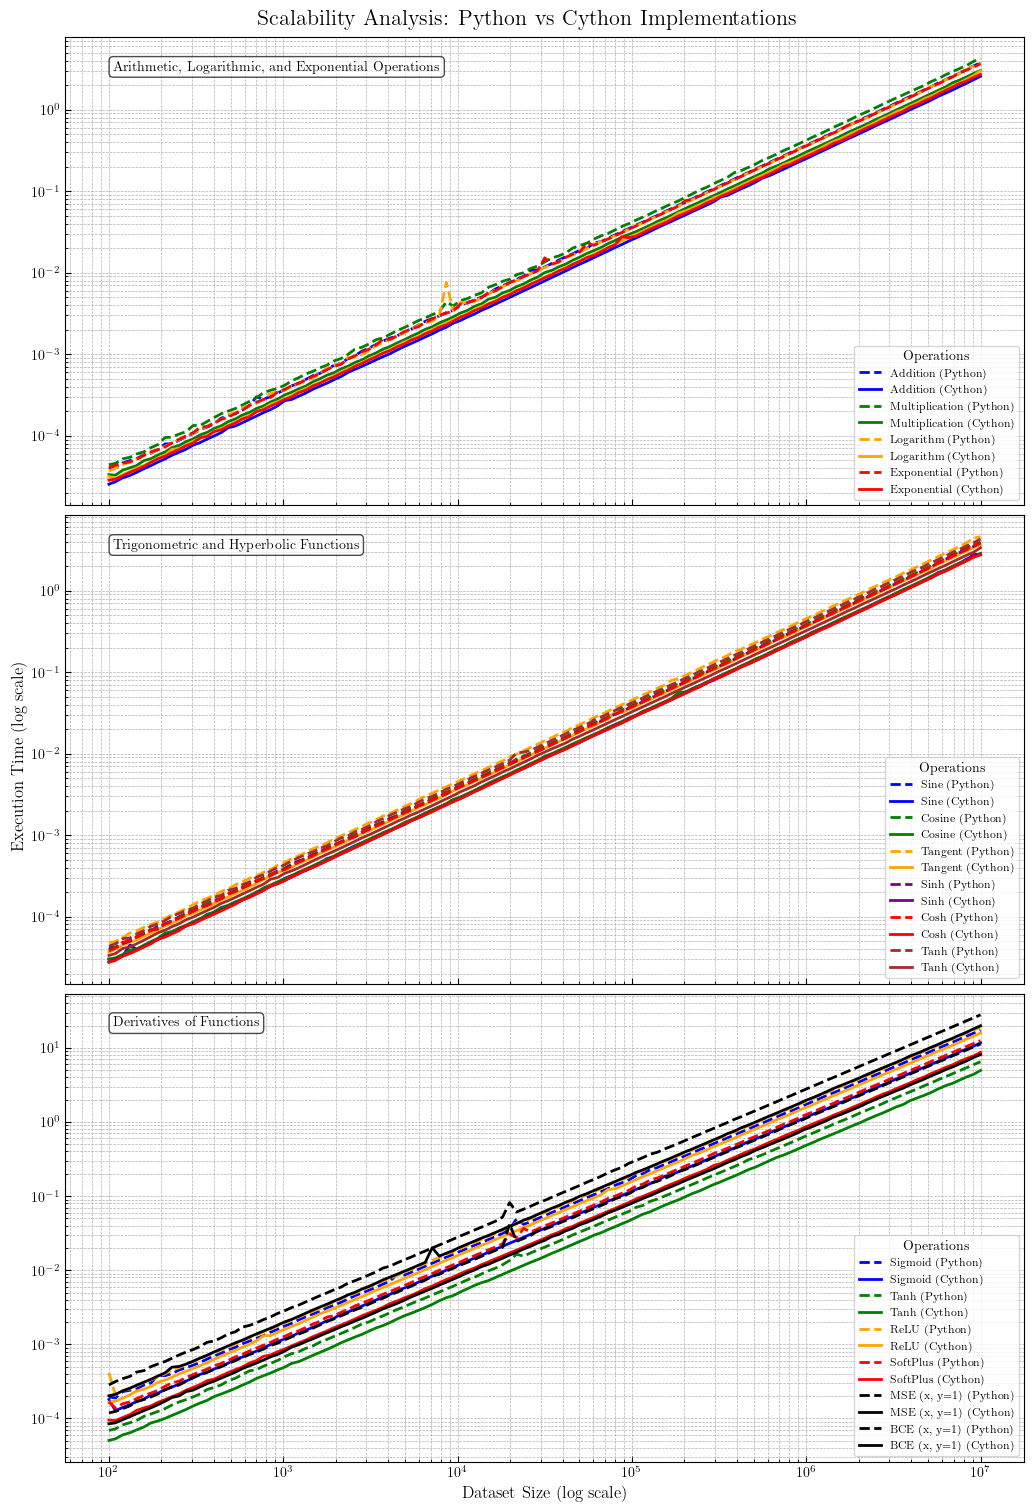

In [67]:
plt.style.use('latex_style.mplstyle')  # Use your updated style


# Define colors for plots
arithmetic_colors = {"Addition": "blue", "Multiplication": "green"}
logarithmic_colors = {"Logarithm": "orange", "Exponential": "red"}
trig_hyperbolic_colors = {"Sine": "blue", "Cosine": "green", "Tangent": "orange", 
                          "Sinh": "purple", "Cosh": "red", "Tanh": "brown"}
derivative_colors = {
    "Sigmoid": "blue", 
    "Tanh": "green", 
    "ReLU": "orange", 
    "SoftPlus": "red", 
    "MSE": "purple", 
    "BCE": "brown"
}  # Removed "Sin-Cos Product"

# Plot scalability results
def plot_scalability_subplots(dataset_sizes, results_python, results_cython, colors, ax, subplot_title, legend_loc):
    """
    Plots the scalability results for a specific category of operations in a subplot.

    Args:
        dataset_sizes: The dataset sizes used for the benchmark.
        results_python: Timing results for Python implementation.
        results_cython: Timing results for Cython implementation.
        colors: Dictionary mapping operations to colors.
        ax: Subplot axis to plot on.
        subplot_title: Title of the subplot.
        legend_loc: Location of the legend in the subplot.
    """
    for op in results_python.keys():
        ax.plot(dataset_sizes, results_python[op], label=f"{op} (Python)", linestyle="--", linewidth=2, color=colors.get(op, "black"))
        ax.plot(dataset_sizes, results_cython[op], label=f"{op} (Cython)", linestyle="-", linewidth=2, color=colors.get(op, "black"))
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax.legend(loc=legend_loc, fontsize=8, title="Operations")
    ax.text(0.05, 0.95, subplot_title, transform=ax.transAxes, fontsize=10, fontweight='bold', va='top', ha='left', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True, constrained_layout=True)
fig.suptitle("Scalability Analysis: Python vs Cython Implementations", fontsize=16, fontweight='bold')

# Plot arithmetic, logarithmic, and exponential operations
plot_scalability_subplots(
    dataset_sizes, 
    results_python_arithmetic_log, 
    results_cython_arithmetic_log, 
    colors={**arithmetic_colors, **logarithmic_colors}, 
    ax=axes[0], 
    subplot_title="Arithmetic, Logarithmic, and Exponential Operations", 
    legend_loc="lower right"
)

# Plot trigonometric and hyperbolic functions
plot_scalability_subplots(
    dataset_sizes, 
    results_python_trig_hyperbolic, 
    results_cython_trig_hyperbolic, 
    trig_hyperbolic_colors, 
    ax=axes[1], 
    subplot_title="Trigonometric and Hyperbolic Functions", 
    legend_loc="lower right"
)

# Plot derivatives of functions
plot_scalability_subplots(
    dataset_sizes, 
    results_python_differentiate, 
    results_cython_differentiate, 
    derivative_colors, 
    ax=axes[2], 
    subplot_title="Derivatives of Functions", 
    legend_loc="lower right"
)

# Add labels for the x-axis and a shared y-axis label
axes[-1].set_xlabel("Dataset Size (log scale)")
fig.text(-0.01, 0.5, "Execution Time (log scale)", va='center', ha='center', rotation='vertical', fontsize=12)

# Save the figure as a PDF
plt.savefig("scalability_combined.pdf", format="pdf", bbox_inches="tight")
plt.show()


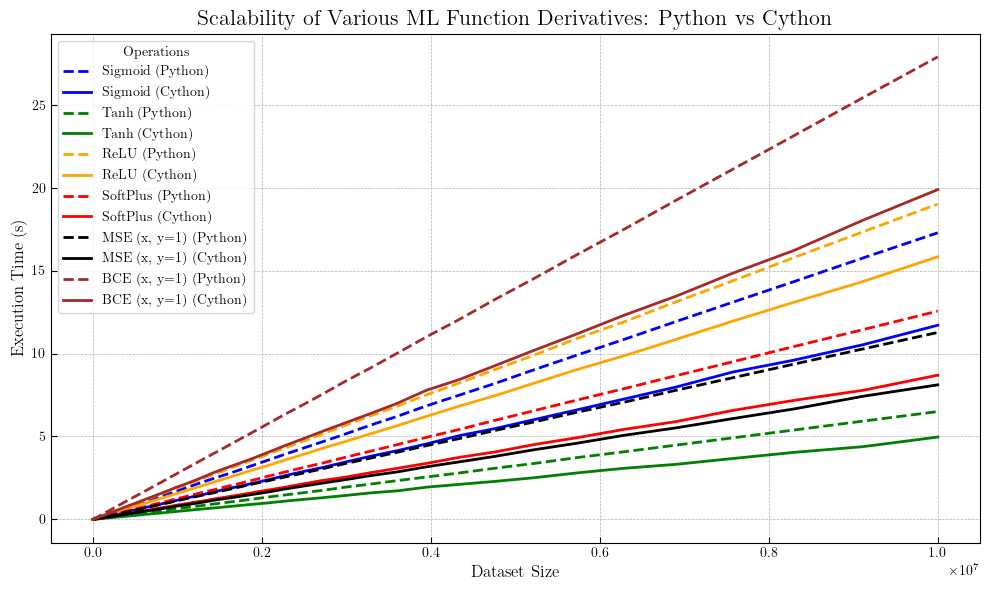

In [74]:
derivative_colors = {
    "Sigmoid": "blue",
    "Tanh": "green",
    "ReLU": "orange",
    "SoftPlus": "red",
    "MSE (x, y=1)": "black",  
    "BCE (x, y=1)": "brown" 
}


# Define a function to plot just the derivatives on a log-log scale
def plot_derivative_scalability(dataset_sizes, results_python, results_cython, colors, title, legend_loc, save_path):
    """
    Plot the scalability of derivative calculations comparing Python and Cython implementations.

    Args:
        dataset_sizes: The dataset sizes used for benchmarking.
        results_python: Timing results for Python implementation.
        results_cython: Timing results for Cython implementation.
        colors: A dictionary mapping operations to specific colors.
        title: The title of the plot.
        legend_loc: The location of the legend on the plot.
        save_path: The file path to save the plot as a PDF.
    """
    plt.figure(figsize=(10, 6))
    for op in results_python.keys():
        plt.plot(dataset_sizes, results_python[op], label=f"{op} (Python)", linestyle="--", linewidth=2, color=colors.get(op, "black"))
        plt.plot(dataset_sizes, results_cython[op], label=f"{op} (Cython)", linestyle="-", linewidth=2, color=colors.get(op, "black"))

    # plt.xscale("log")
    # plt.yscale("log")

    plt.xlabel("Dataset Size", fontsize=12)
    plt.ylabel("Execution Time (s)", fontsize=12)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.legend(loc=legend_loc, fontsize=10, title="Operations")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.savefig(save_path, format="pdf", bbox_inches="tight")  # Save the plot
    plt.show()

# Plot the derivatives scalability
plot_derivative_scalability(
    dataset_sizes,
    results_python_differentiate,
    results_cython_differentiate,
    derivative_colors,
    "Scalability of Various ML Function Derivatives: Python vs Cython",
    legend_loc="upper left",
    save_path="derivative_scalability.pdf"  # Specify the save path
)


# **Scaling Analysis: Execution Time vs Dataset Size**

This section evaluates the relationship between execution time and dataset size for Python and Cython implementations. The analysis computes the gradient ($K$) and constant overhead ($C$) for each derivative function.

---

## **Methodology**

1. **Linear Relationship**:
   $T(N) = K \cdot N + C$
   - $T(N)$: Execution time.
   - $N$: Dataset size.
   - $K$: Gradient, representing the per-element computation cost.
   - $C$: Fixed computational overhead.

2. **Regression Approach**:
   - A linear regression model is applied to the data, accounting for outliers to ensure accuracy.
   - Both Python and Cython implementations are analyzed to determine their respective scaling parameters.

3. **Efficiency Comparison**:
   - Percentage reduction in $K$ and $C$ for Cython over Python:
     $ \text{Reduction in } K = \frac{K_{\text{Python}} - K_{\text{Cython}}}{K_{\text{Python}}} \times 100\% $
     $ \text{Reduction in } C = \frac{C_{\text{Python}} - C_{\text{Cython}}}{C_{\text{Python}}} \times 100\% $

---

In [54]:
import numpy as np
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression

# Function to compute scaling parameters K (gradient) and C (constant overhead) using robust regression
def robust_scaling_params_linear(dataset_sizes, execution_times):
    """
    Computes the scaling parameters K (gradient) and C (constant overhead) for linear data using RANSAC.
    
    :param dataset_sizes: Array of dataset sizes (N).
    :param execution_times: Array of execution times (T(N)) for a given operation.
    :return: Tuple (K, C) where K is the gradient and C is the constant overhead.
    """
    dataset_sizes = np.array(dataset_sizes).reshape(-1, 1)  # Reshape to 2D for sklearn
    execution_times = np.array(execution_times)

    # Use RANSAC for robust linear regression
    ransac = RANSACRegressor(estimator=LinearRegression(), random_state=42)
    ransac.fit(dataset_sizes, execution_times)

    gradient = ransac.estimator_.coef_[0]
    intercept = ransac.estimator_.intercept_
    
    return gradient, intercept

# Compute K and C for each derivative function for Python and Cython
def compute_scaling_all_linear(dataset_sizes, results_python, results_cython):
    """
    Computes scaling parameters K and C for all derivative functions for Python and Cython.
    
    :param dataset_sizes: Array of dataset sizes.
    :param results_python: Execution times for Python.
    :param results_cython: Execution times for Cython.
    :return: Dictionaries of (K, C) values for Python and Cython.
    """
    scaling_python = {}
    scaling_cython = {}
    for function_name in results_python.keys():
        K_python, C_python = robust_scaling_params_linear(dataset_sizes, results_python[function_name])
        K_cython, C_cython = robust_scaling_params_linear(dataset_sizes, results_cython[function_name])
        scaling_python[function_name] = (K_python, C_python)
        scaling_cython[function_name] = (K_cython, C_cython)
    return scaling_python, scaling_cython

# Compute scaling parameters for derivatives
scaling_python, scaling_cython = compute_scaling_all_linear(
    dataset_sizes, results_python_differentiate, results_cython_differentiate
)

# Display the results
print("Scaling Parameters (Python):")
for function_name, (K, C) in scaling_python.items():
    print(f"{function_name}: K = {K:.3e}, C = {C:.4e}")

print("\nScaling Parameters (Cython):")
for function_name, (K, C) in scaling_cython.items():
    print(f"{function_name}: K = {K:.3e}, C = {C:.4e}")

# Relative Reduction in K and C
print("\nRelative Reduction in K and C (Cython vs Python):")
for function_name in scaling_python.keys():
    K_python, C_python = scaling_python[function_name]
    K_cython, C_cython = scaling_cython[function_name]
    
    # Reduction in K
    reduction_K = (K_python - K_cython) / K_python * 100 if K_python != 0 else 0
    
    # Reduction in C
    reduction_C = (C_python - C_cython) / C_python * 100 if C_python != 0 else 0
    
    print(f"{function_name}: Reduction in K = {reduction_K:.2f}%, Reduction in C = {reduction_C:.2f}%")


Scaling Parameters (Python):
Sigmoid: K = 1.729e-06, C = -9.1343e-05
Tanh: K = 6.494e-07, C = -3.1893e-04
ReLU: K = 1.901e-06, C = -1.9276e-04
SoftPlus: K = 1.255e-06, C = -2.7722e-04
MSE (x, y=1): K = 1.127e-06, C = -1.0733e-04
BCE (x, y=1): K = 2.788e-06, C = -5.3759e-04

Scaling Parameters (Cython):
Sigmoid: K = 1.158e-06, C = 3.9802e-05
Tanh: K = 4.844e-07, C = -8.1285e-05
ReLU: K = 1.575e-06, C = 1.6800e-05
SoftPlus: K = 8.558e-07, C = 8.8434e-04
MSE (x, y=1): K = 8.020e-07, C = -6.1969e-05
BCE (x, y=1): K = 1.954e-06, C = 8.6646e-05

Relative Reduction in K and C (Cython vs Python):
Sigmoid: Reduction in K = 33.03%, Reduction in C = 143.57%
Tanh: Reduction in K = 25.41%, Reduction in C = 74.51%
ReLU: Reduction in K = 17.15%, Reduction in C = 108.72%
SoftPlus: Reduction in K = 31.84%, Reduction in C = 419.01%
MSE (x, y=1): Reduction in K = 28.86%, Reduction in C = 42.26%
BCE (x, y=1): Reduction in K = 29.91%, Reduction in C = 116.12%


# **Visualization of Relative Percentage Performance Difference**

This section presents the relative percentage difference in execution times between Python-based and Cython-based implementations across various operations, including arithmetic, trigonometric, and derivative computations. The results are smoothed to highlight meaningful trends.

---

## **Key Features of the Plot**

1. **Relative Percentage Difference**:
   - Defined as:
     $$
     \text{Relative Difference (\%)} = \left( \frac{\text{Time (Python)}}{\text{Time (Cython)}} - 1 \right) \times 100
     $$
   - **Positive Values**: Python is slower than Cython.
   - **Negative Values**: Python is faster than Cython.

2. **Outlier Removal**:
   - Outliers are detected and removed using the Interquartile Range (IQR) method:
     $$
     \text{Lower Bound} = Q1 - 1.5 \times \text{IQR}, \quad \text{Upper Bound} = Q3 + 1.5 \times \text{IQR}
     $$
   - This ensures the focus remains on consistent performance trends.

3. **Smoothing**:
   - The Savitzky-Golay filter is applied to the relative difference values:
     - Window Length: 8.
     - Polynomial Order: 2.
   - This reduces noise and emphasizes the underlying trends in relative performance.


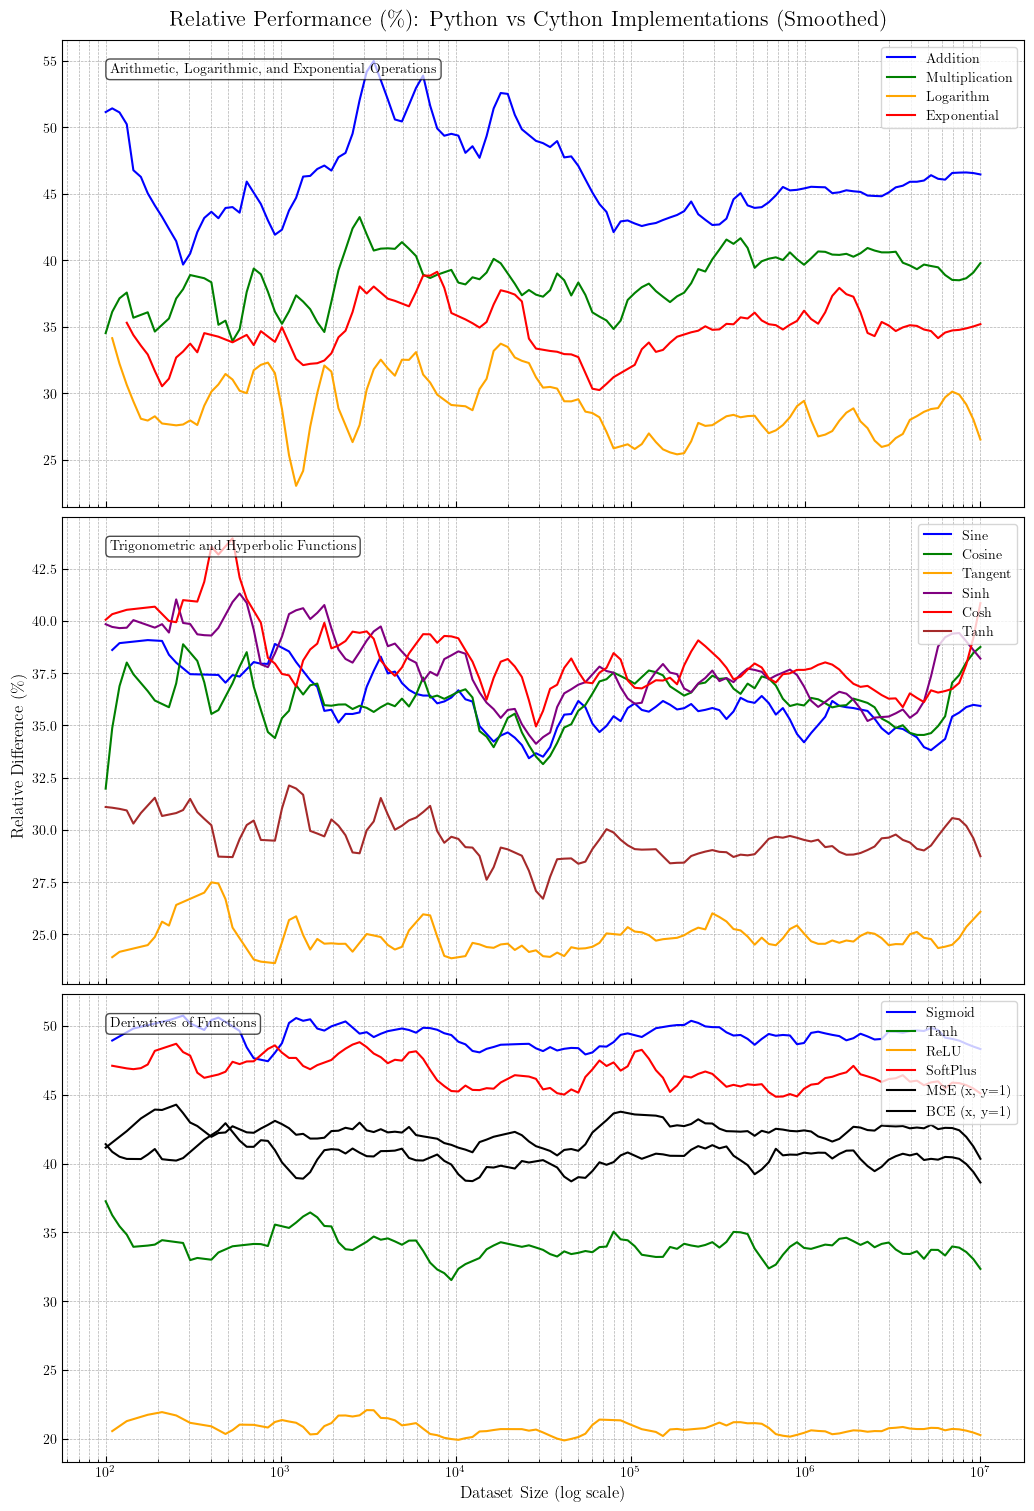

In [70]:
from scipy.signal import savgol_filter
import numpy as np
import matplotlib.pyplot as plt

# Define a function to plot relative percentage difference with smoothing
def plot_relative_percentage_difference_subplots(dataset_sizes, results_python, results_cython, ax, colors, subplot_title):
    """
    Plots the relative percentage difference between Python and Cython implementations
    with smoothing and outlier removal.
    """
    for op in results_python.keys():
        # Compute relative percentage difference
        relative_diff = ((np.array(results_python[op]) / np.array(results_cython[op])) - 1) * 100

        # Outlier removal using IQR
        q1, q3 = np.percentile(relative_diff, [25, 75])
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        valid = (relative_diff >= lower) & (relative_diff <= upper)

        # Filter dataset sizes and relative differences
        filtered_sizes, filtered_diff = np.array(dataset_sizes)[valid], relative_diff[valid]

        # Apply Savitzky-Golay smoothing to the filtered data
        if len(filtered_diff) > 5:  # Ensure there are enough points for smoothing
            smoothed_diff = savgol_filter(filtered_diff, window_length=8, polyorder=2)
        else:
            smoothed_diff = filtered_diff  # Skip smoothing if not enough points

        # Plot the smoothed results
        ax.plot(filtered_sizes, smoothed_diff, label=op, linestyle="-", linewidth=1.5, color=colors.get(op, "black"))
    
    ax.set_xscale("log")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax.text(0.05, 0.95, subplot_title, transform=ax.transAxes, fontsize=10, fontweight='bold', va='top', ha='left', 
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))  # Subplot title inside the plot
    ax.legend(loc="upper right", fontsize=10, title="")  # Add legend

# Define colors for better visualization
arithmetic_log_colors = {"Addition": "blue", "Multiplication": "green", "Logarithm": "orange", "Exponential": "red"}
trig_hyperbolic_colors = {
    "Sine": "blue", "Cosine": "green", "Tangent": "orange",
    "Sinh": "purple", "Cosh": "red", "Tanh": "brown"
}
derivative_colors = {
    "Sigmoid": "blue", 
    "Tanh": "green", 
    "ReLU": "orange", 
    "SoftPlus": "red", 
    "MSE": "purple", 
    "BCE": "brown"
}  # Removed "Sin-Cos Product"

# Create the figure and subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True, constrained_layout=True)

# Grand title for the entire figure
fig.suptitle("Relative Performance (\%): Python vs Cython Implementations (Smoothed)", fontsize=16, fontweight='bold')

# Plot results for Arithmetic and Logarithmic/Exponential operations
plot_relative_percentage_difference_subplots(
    dataset_sizes,
    results_python_arithmetic_log,
    results_cython_arithmetic_log,
    ax=axes[0],
    colors=arithmetic_log_colors,
    subplot_title="Arithmetic, Logarithmic, and Exponential Operations"
)

# Plot results for Trigonometric and Hyperbolic functions
plot_relative_percentage_difference_subplots(
    dataset_sizes,
    results_python_trig_hyperbolic,
    results_cython_trig_hyperbolic,
    ax=axes[1],
    colors=trig_hyperbolic_colors,
    subplot_title="Trigonometric and Hyperbolic Functions"
)

# Plot results for Derivatives of Functions
plot_relative_percentage_difference_subplots(
    dataset_sizes,
    results_python_differentiate,
    results_cython_differentiate,
    ax=axes[2],
    colors=derivative_colors,
    subplot_title="Derivatives of Functions"
)

# Add labels only on the bottom plot
axes[-1].set_xlabel("Dataset Size (log scale)")

# Set a shared y-axis label
fig.text(-0.01, 0.5, "Relative Difference (\%)", va='center', ha='center', rotation='vertical', fontsize=12)

# Save the entire figure as a single PDF
plt.savefig("relative_performance_combined_smooth.pdf", format="pdf", bbox_inches="tight")
plt.show()
